<a href="https://colab.research.google.com/github/Swastik200/30DaysOfDSA/blob/main/CNNLSTMU1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# print(os.listdir("../input"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/CMAPSSData.zip" "/content"
!unzip CMAPSSData.zip

Mounted at /content/drive
Archive:  CMAPSSData.zip
  inflating: CMAPSS/RUL_FD001.txt    
  inflating: CMAPSS/RUL_FD002.txt    
  inflating: CMAPSS/RUL_FD003.txt    
  inflating: CMAPSS/RUL_FD004.txt    
  inflating: CMAPSS/test_FD001.txt   
  inflating: CMAPSS/test_FD002.txt   
  inflating: CMAPSS/test_FD003.txt   
  inflating: CMAPSS/test_FD004.txt   
  inflating: CMAPSS/train_FD001.txt  
  inflating: CMAPSS/train_FD002.txt  
  inflating: CMAPSS/train_FD003.txt  
  inflating: CMAPSS/train_FD004.txt  
  inflating: CMAPSS/x.txt            


In [3]:
dataPath = '/content/CMAPSS/'

In [4]:
setNumber = 1

In [5]:
id_col = ['id']
cycle_col = ['cycle']
setting_cols = ['setting1', 'setting2', 'setting3']
sensor_cols = ['sensor' + str(i) for i in range(1, 22)]
rul_col = ['RUL']
all_cols = id_col + cycle_col + setting_cols + sensor_cols + rul_col

In [6]:
# This section is to load data
def loadData(fileName):
    data = pd.read_csv(fileName, sep=" ", header=None)
    data.drop([26, 27], axis = 1, inplace=True)
    data.columns = id_col + cycle_col + setting_cols +sensor_cols
    return data

In [7]:
# load train RUL also returns the max cycle, and this max cycle is also the life cylce
def addTrainRul(data, decrease_threshold=None):
    lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() for mcId in data['id'].unique()}
    if decrease_threshold == None: decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles

# use this last one only, return the data as well as the max life cycles
def loadTrainData(setNumber, decrease_threshold=None):
    fileName = dataPath + '/train_FD00' + str(setNumber) + '.txt'
    data = loadData(fileName)
    lifeCycles = addTrainRul(data, decrease_threshold)
    return data, lifeCycles

In [8]:
decrease_threshold = None
train, trainLifeCycles = loadTrainData(setNumber, decrease_threshold)

In [9]:
def loadTestRul(fileName):
    data = pd.read_csv(fileName, sep = " ", header=None)
    data.drop([1], axis=1, inplace=True)
    data.columns = ['RUL']
    return data
def addTestRul(data, rulData, decrease_threshold=None):
    testRuls = {i+1: rulData.iloc[i, 0] for i in range(len(rulData))}
    lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() + testRuls[mcId] for mcId in data['id'].unique()}
    if decrease_threshold == None: decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles
# Use this last one only => return data as well as the max life cycles for each machine
def loadTestData(setNumber, decrease_threshold=None):
    data = loadData(dataPath + '/test_FD00' +str(setNumber)+'.txt')
    rulData = loadTestRul(dataPath + '/RUL_FD00' + str(setNumber)+'.txt')
    lifeCycles = addTestRul(data, rulData, decrease_threshold)
    return data, lifeCycles

In [10]:
# Also make test RUL becomes piecewise
test, testLifeCycles = loadTestData(setNumber, decrease_threshold)

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

In [12]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20  (manual selection based on sensor trends)
def plotSensorDataOfId(data, mcId):
    plt.figure(figsize=(30, 20))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        plt.subplot(10, 3, i+1).set_title(sensor)
        ssdata = data[data['id']==mcId]
        plt.plot(ssdata['cycle'], ssdata[sensor])
    plt.tight_layout()

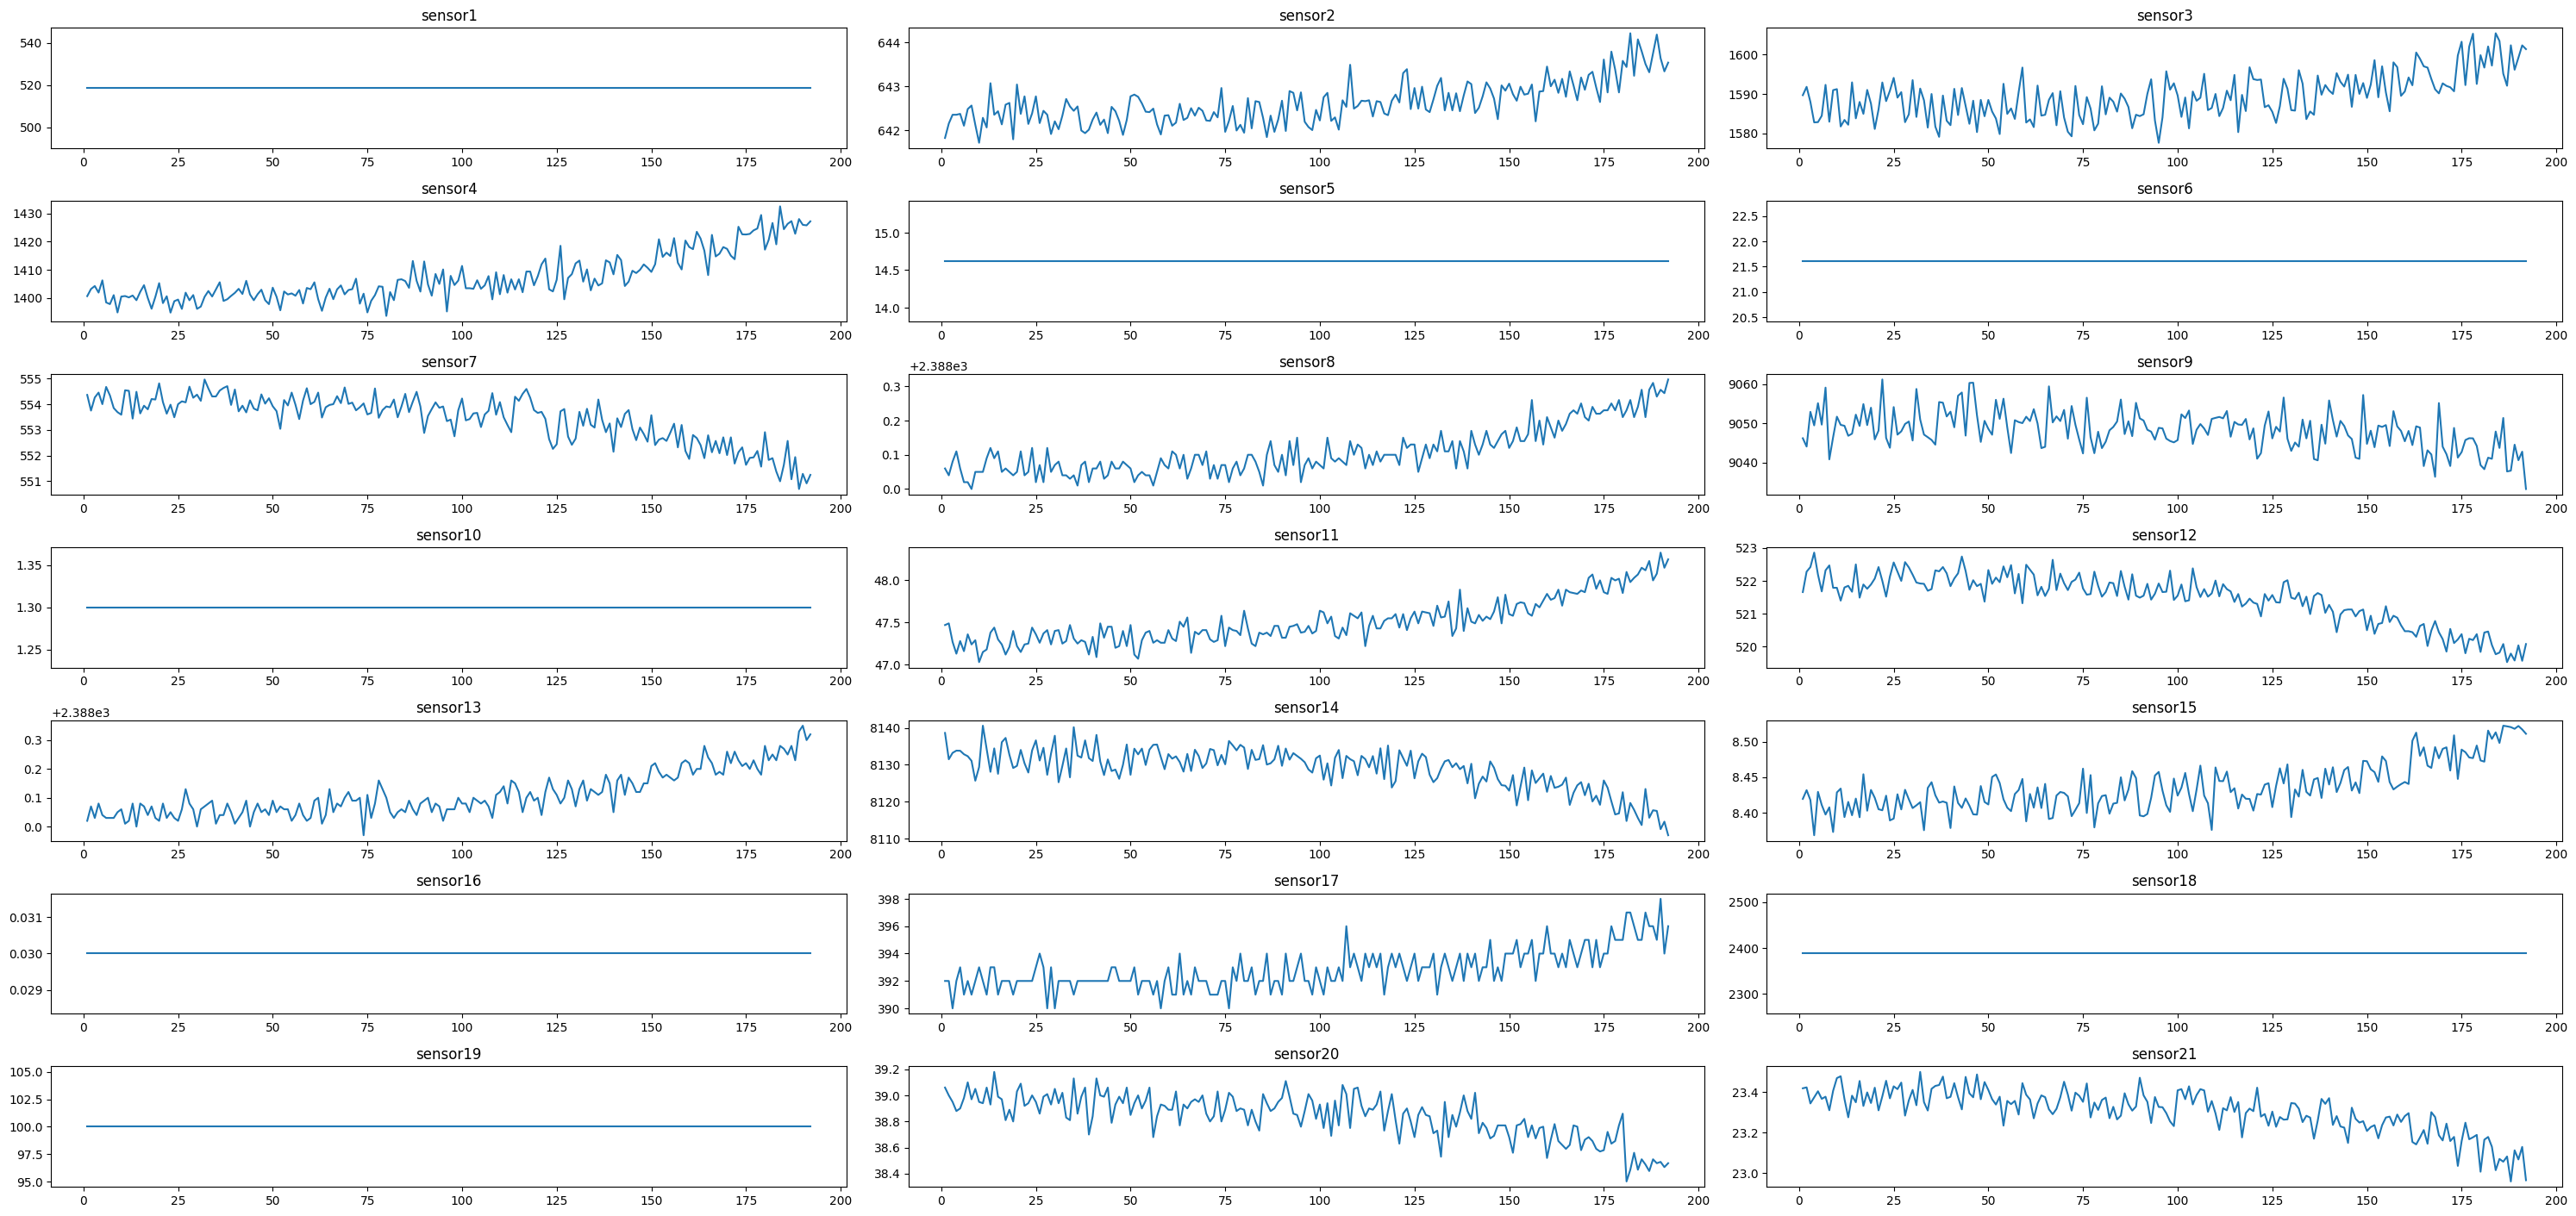

In [13]:
plotSensorDataOfId(train, 1)

In [14]:
def plotDataDistribution(data):
    sensors = []
    plt.figure(figsize=(30, 10))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        if(len(data[sensor].unique())>1):
            sensors.append(sensor)
            plt.subplot(3, 10, i+1)
            sns.distplot(data[sensor])
    plt.tight_layout()
    return sensors

<ipython-input-14-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-14-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-14-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed 

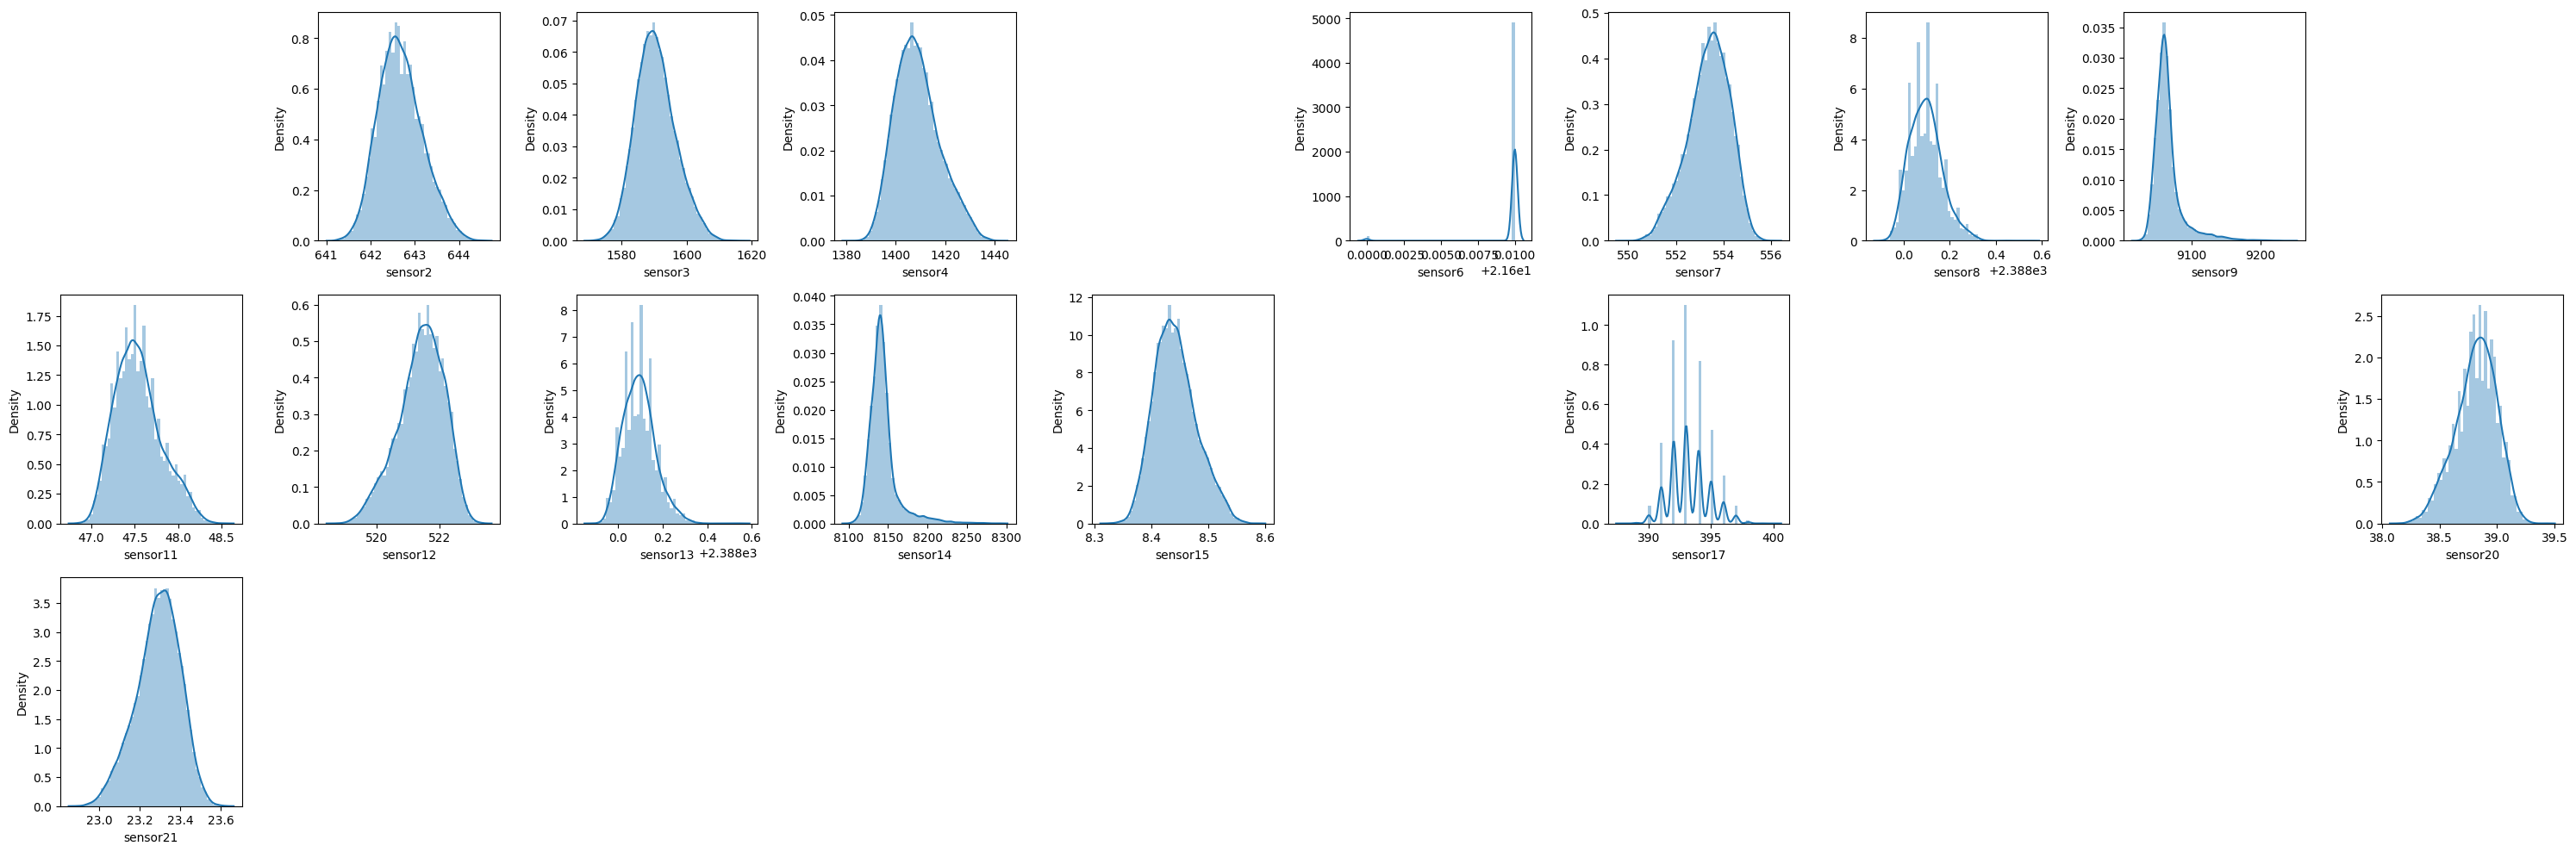

In [15]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20 => Why 16?
cols = plotDataDistribution(train)

In [16]:
def plotCorrelation(data):
    corr = data.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 10))
    sns.heatmap(data.corr(), square=True, mask=mask, cbar_kws={"shrink": 0.5})

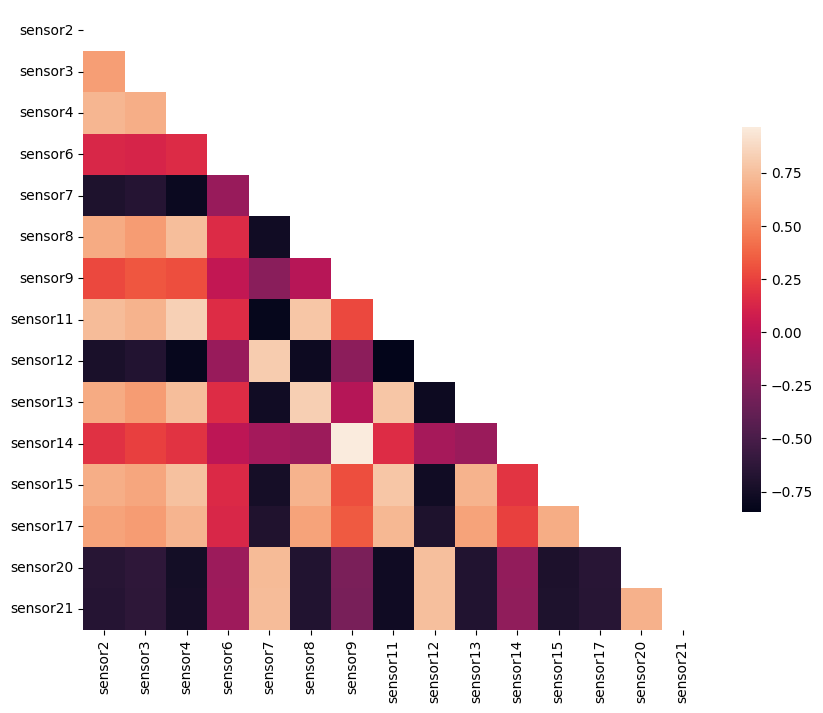

In [17]:
plotCorrelation(train[cols])

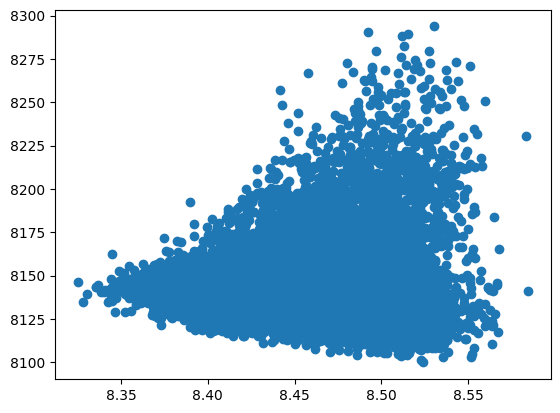

In [18]:
plt.scatter(train['sensor15'].values, train['sensor14'].values)

In [19]:
def plotCorrelationOfID(data, mcId):
    data1 = data[data['id']==mcId]
    data1 = data1.drop(['id'], axis = 1)
    corr = data1.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 10))
    sns.heatmap(data1.corr(), square=True, mask=mask, cbar_kws={"shrink": 0.5})

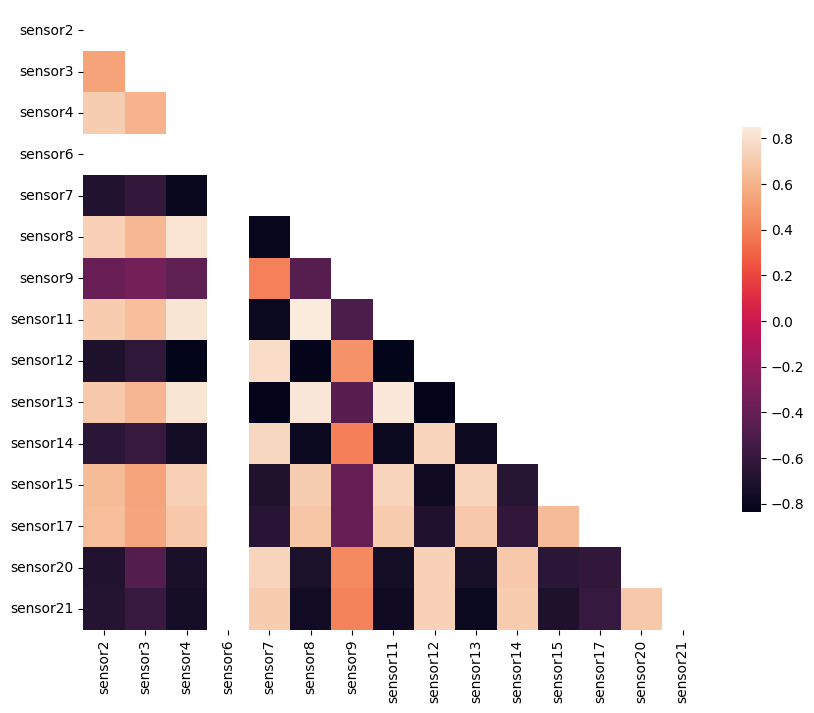

In [20]:
plotCorrelationOfID(train[['id']+cols], 1)

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [22]:
# Scale the data and return the scaled data in form of a df and the scaler (will generate the scaler if doesn't pass it)
def scaleData(data, scaler=None):
    scaled_fields = setting_cols+sensor_cols
    if scaler == None:
        scaler = StandardScaler().fit(data[scaled_fields].values)
#         scaler = MinMaxScaler().fit(data[scaled_fields].values)
    scaled_data = scaler.transform(data[scaled_fields].values)
    scaled_df0 = pd.DataFrame(scaled_data)
    scaled_df0.columns = scaled_fields
    scaled_df1 = data.copy()
    for i in range(len(scaled_fields)):
        theField = scaled_fields[i]
        scaled_df1[theField] = scaled_df0[theField]
    return scaled_df1, scaler

In [23]:
# Scaled train
scaled_train, scaler = scaleData(train)
# Scaled test
scaled_test, scaler = scaleData(test, scaler)

<ipython-input-14-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-14-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-14-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed 

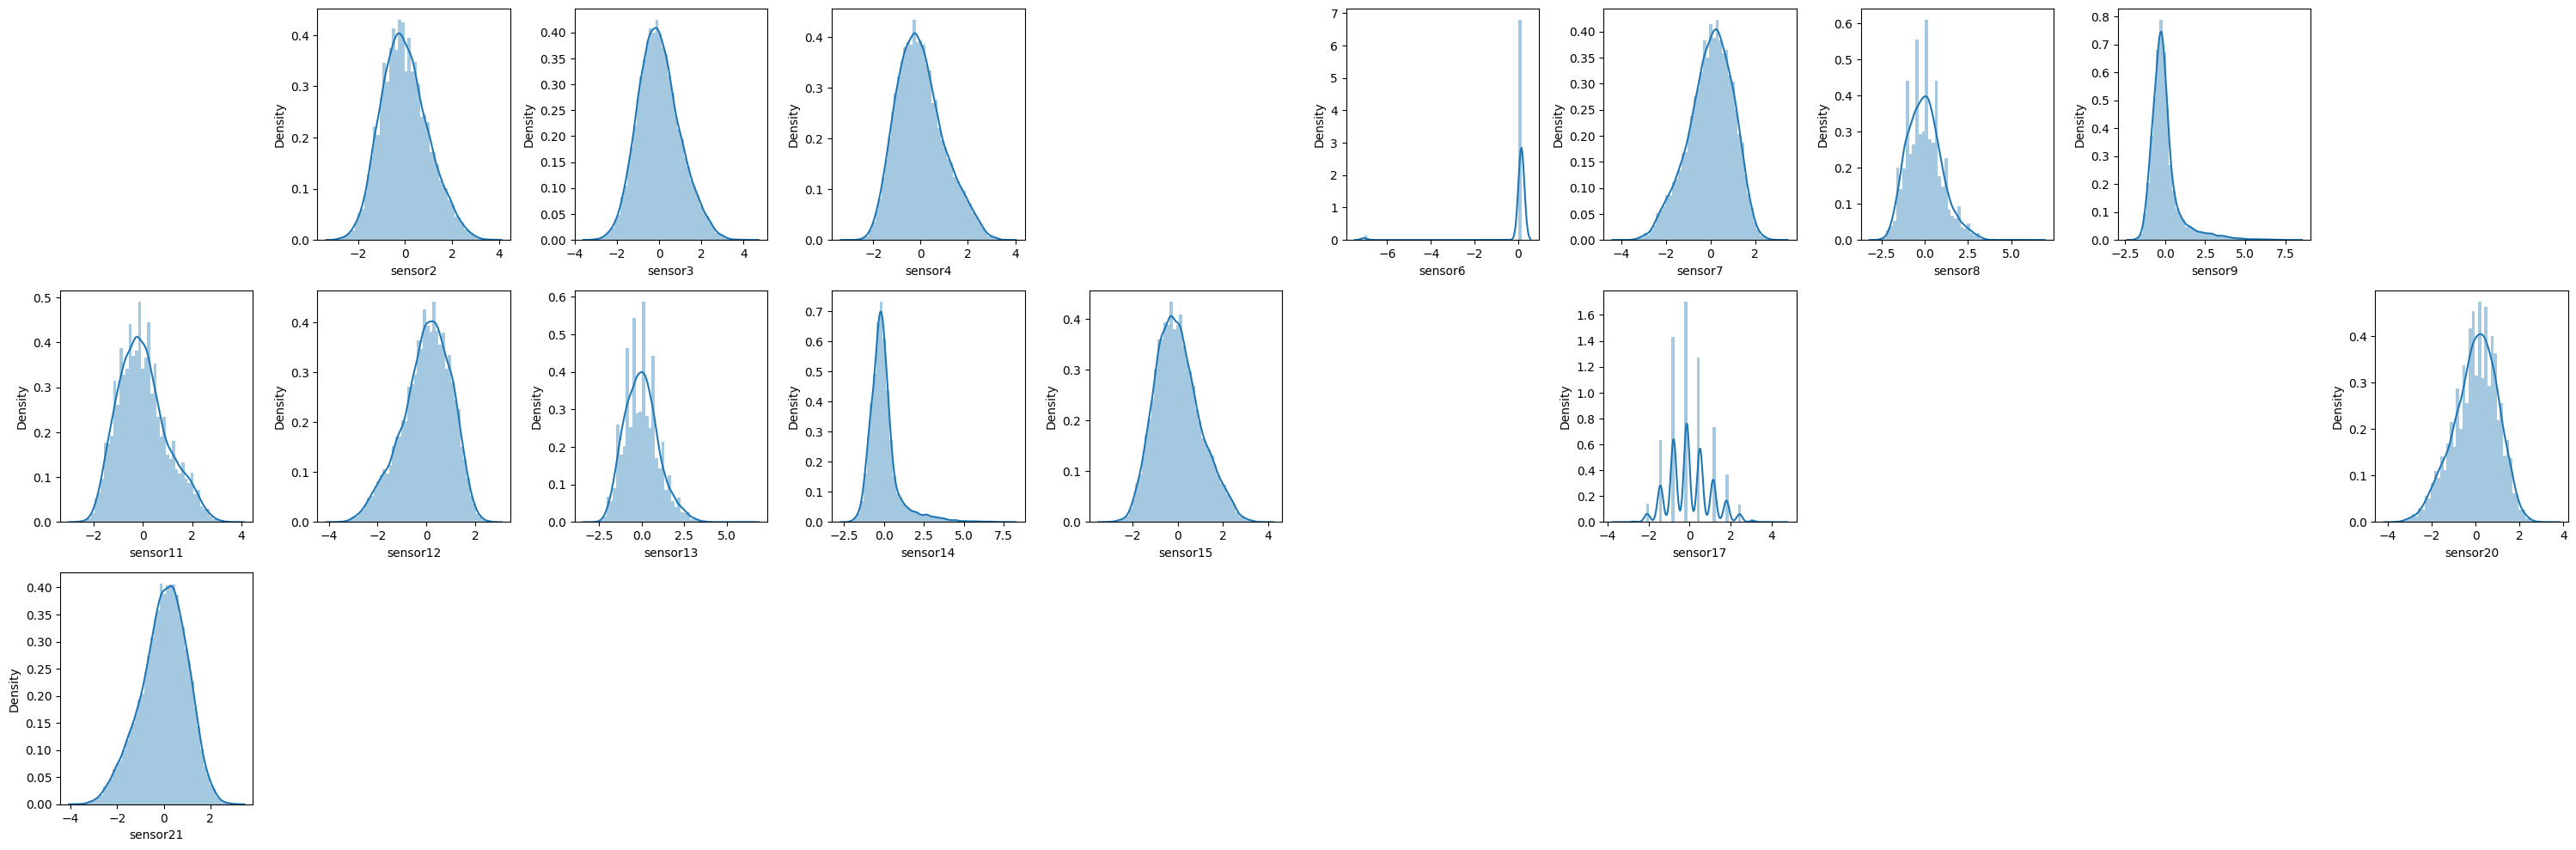

In [24]:
# plot to make sure that the scaled data still keep its shape.
cols = plotDataDistribution(scaled_train)

<ipython-input-14-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-14-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-14-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed 

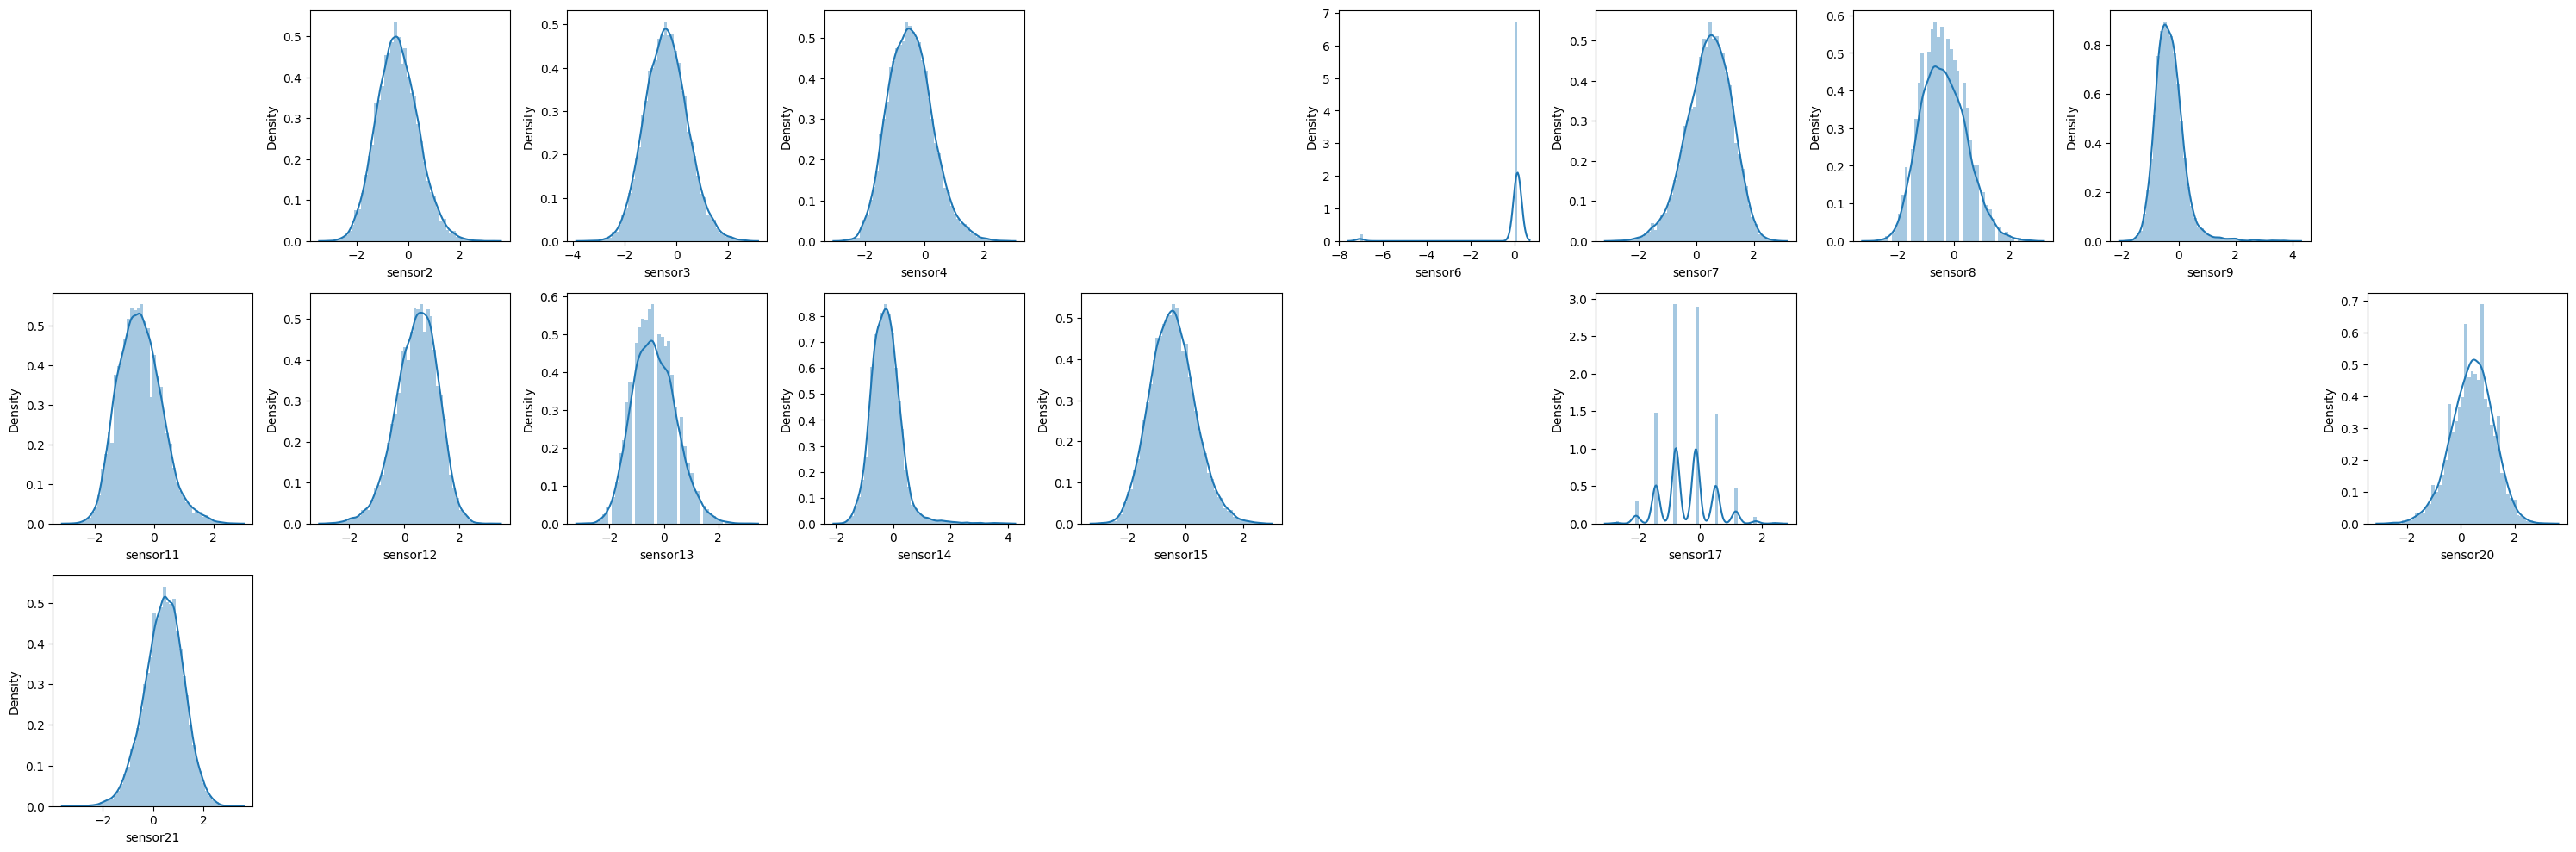

In [25]:
#plot to see if the data keeps its distribution
cols = plotDataDistribution(scaled_test)

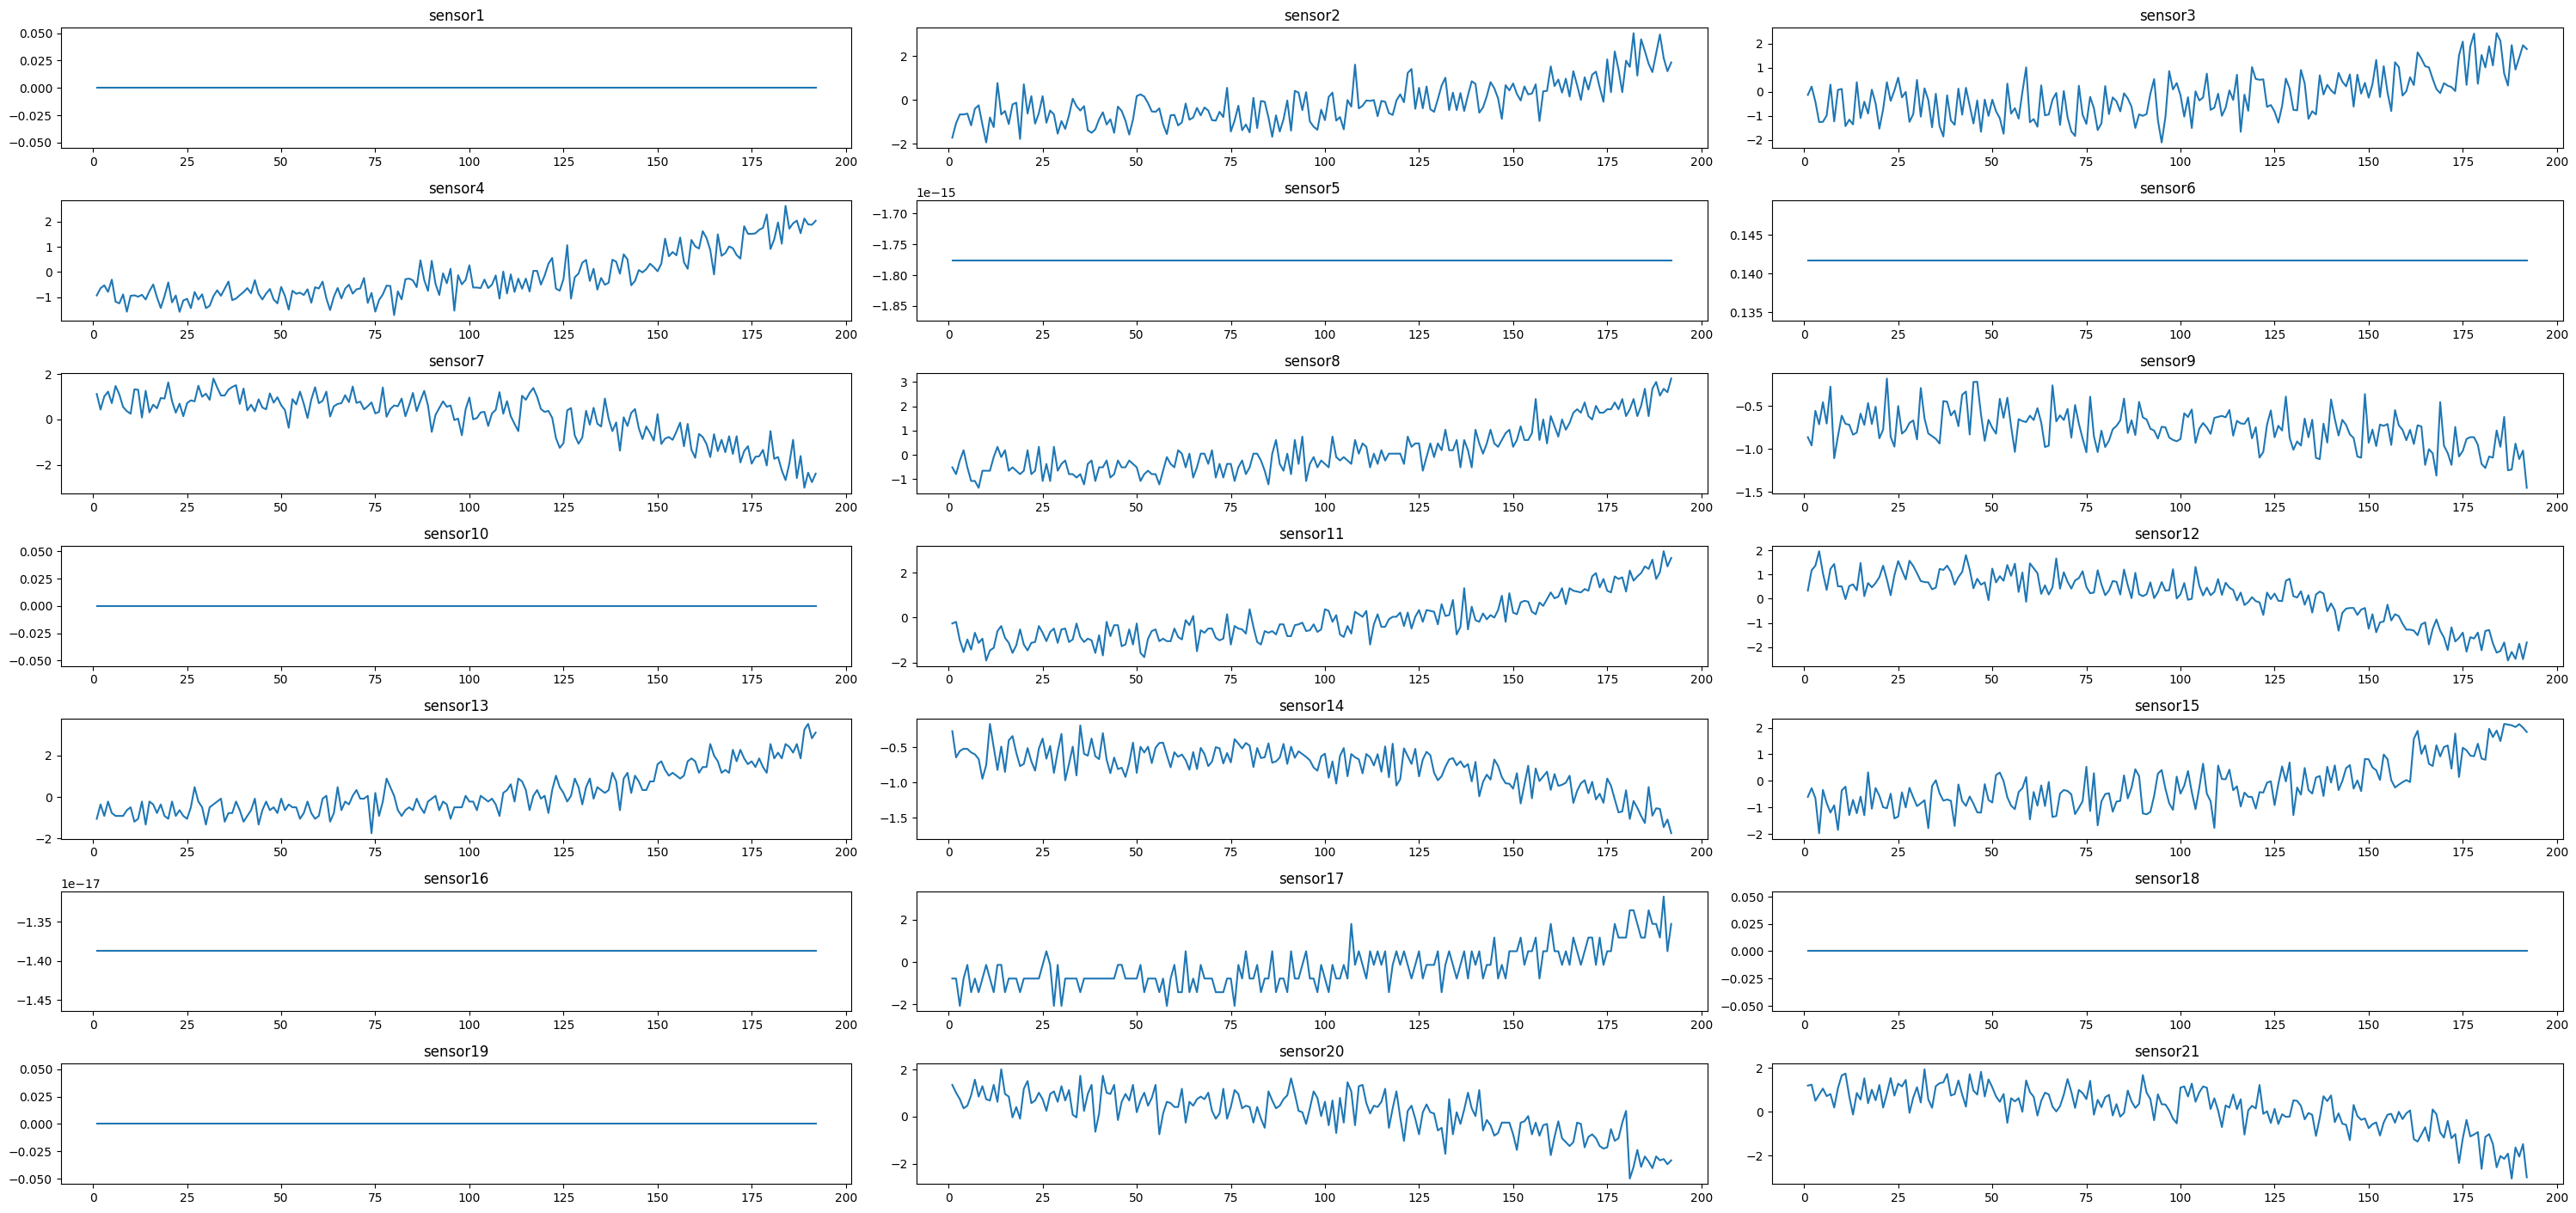

In [26]:
plotSensorDataOfId(scaled_train, 1)

In [27]:
import random
def getPieceWiseData(data, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    uniqueIds = data['id'].unique()
    if movingAverage==None:
        result = [data[data['id']==mId].values for mId in uniqueIds]
    else:
        result = [data[data['id']==mId].rolling(movingAverage).mean().dropna().values for mId in uniqueIds]
    maxlen = np.max([len(x) for x in result])
    #Augment the data now
    if(augmentStartCycle!=None and augmentEndCycle!= None):
        result1 = []
        for mc in result:
            maxCycle = len(mc)
            for i in range(50):
                idx = random.randint(max([maxCycle-145, 10]), max([maxCycle-10, 10]))
                if(len(mc[:idx, :])>0):
                    result1.append(mc[:idx, :])
            #Also add the complete sequence.
#             result1.append(mc)
        result = result1
    # calculate the ruls (-1) is the last column for RUL
    ruls = [min(mc[:, -1]) for mc in result]
    return result,ruls, maxlen
# Use this last one only (prev one is a helper)
from keras.preprocessing.sequence import pad_sequences
def getPaddedSequence(data, pad_type='pre', maxlen=None, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    piece_wise, ruls, ml = getPieceWiseData(data, augmentStartCycle, augmentEndCycle, movingAverage)
    if(maxlen==None): maxlen = ml
    padded_sequence = pad_sequences(piece_wise, padding=pad_type, maxlen=maxlen, dtype='float32')
    return padded_sequence, ruls, maxlen

In [28]:
augmentStartCycle = 130
augmentEndCycle = 362
maxlen=200
movingAverage = None
padded_train, train_ruls, maxlen = getPaddedSequence(scaled_train, maxlen=maxlen, augmentStartCycle=augmentStartCycle, augmentEndCycle=augmentEndCycle, movingAverage=movingAverage)
padded_test, test_ruls, maxlen = getPaddedSequence(scaled_test, maxlen=maxlen, movingAverage=movingAverage)

<ipython-input-29-4b30e61fb37a>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_ruls)


<Axes: ylabel='Density'>

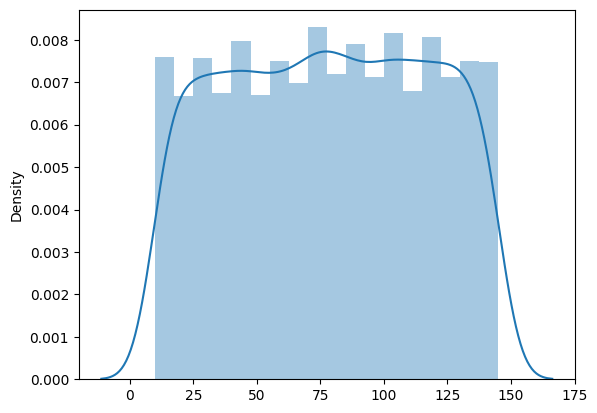

In [29]:
sns.distplot(train_ruls)

In [30]:
def plotDataForIndex(data, theIndex):
    plt.figure(figsize=(30, 30))
    for i in range(5, 26):
        plt.subplot(7, 3, i-4)
        values = data[theIndex][:, i]
        plt.plot(range(len(values)) ,values)
        plt.title('sensor'+str(i-4))
        plt.tight_layout()

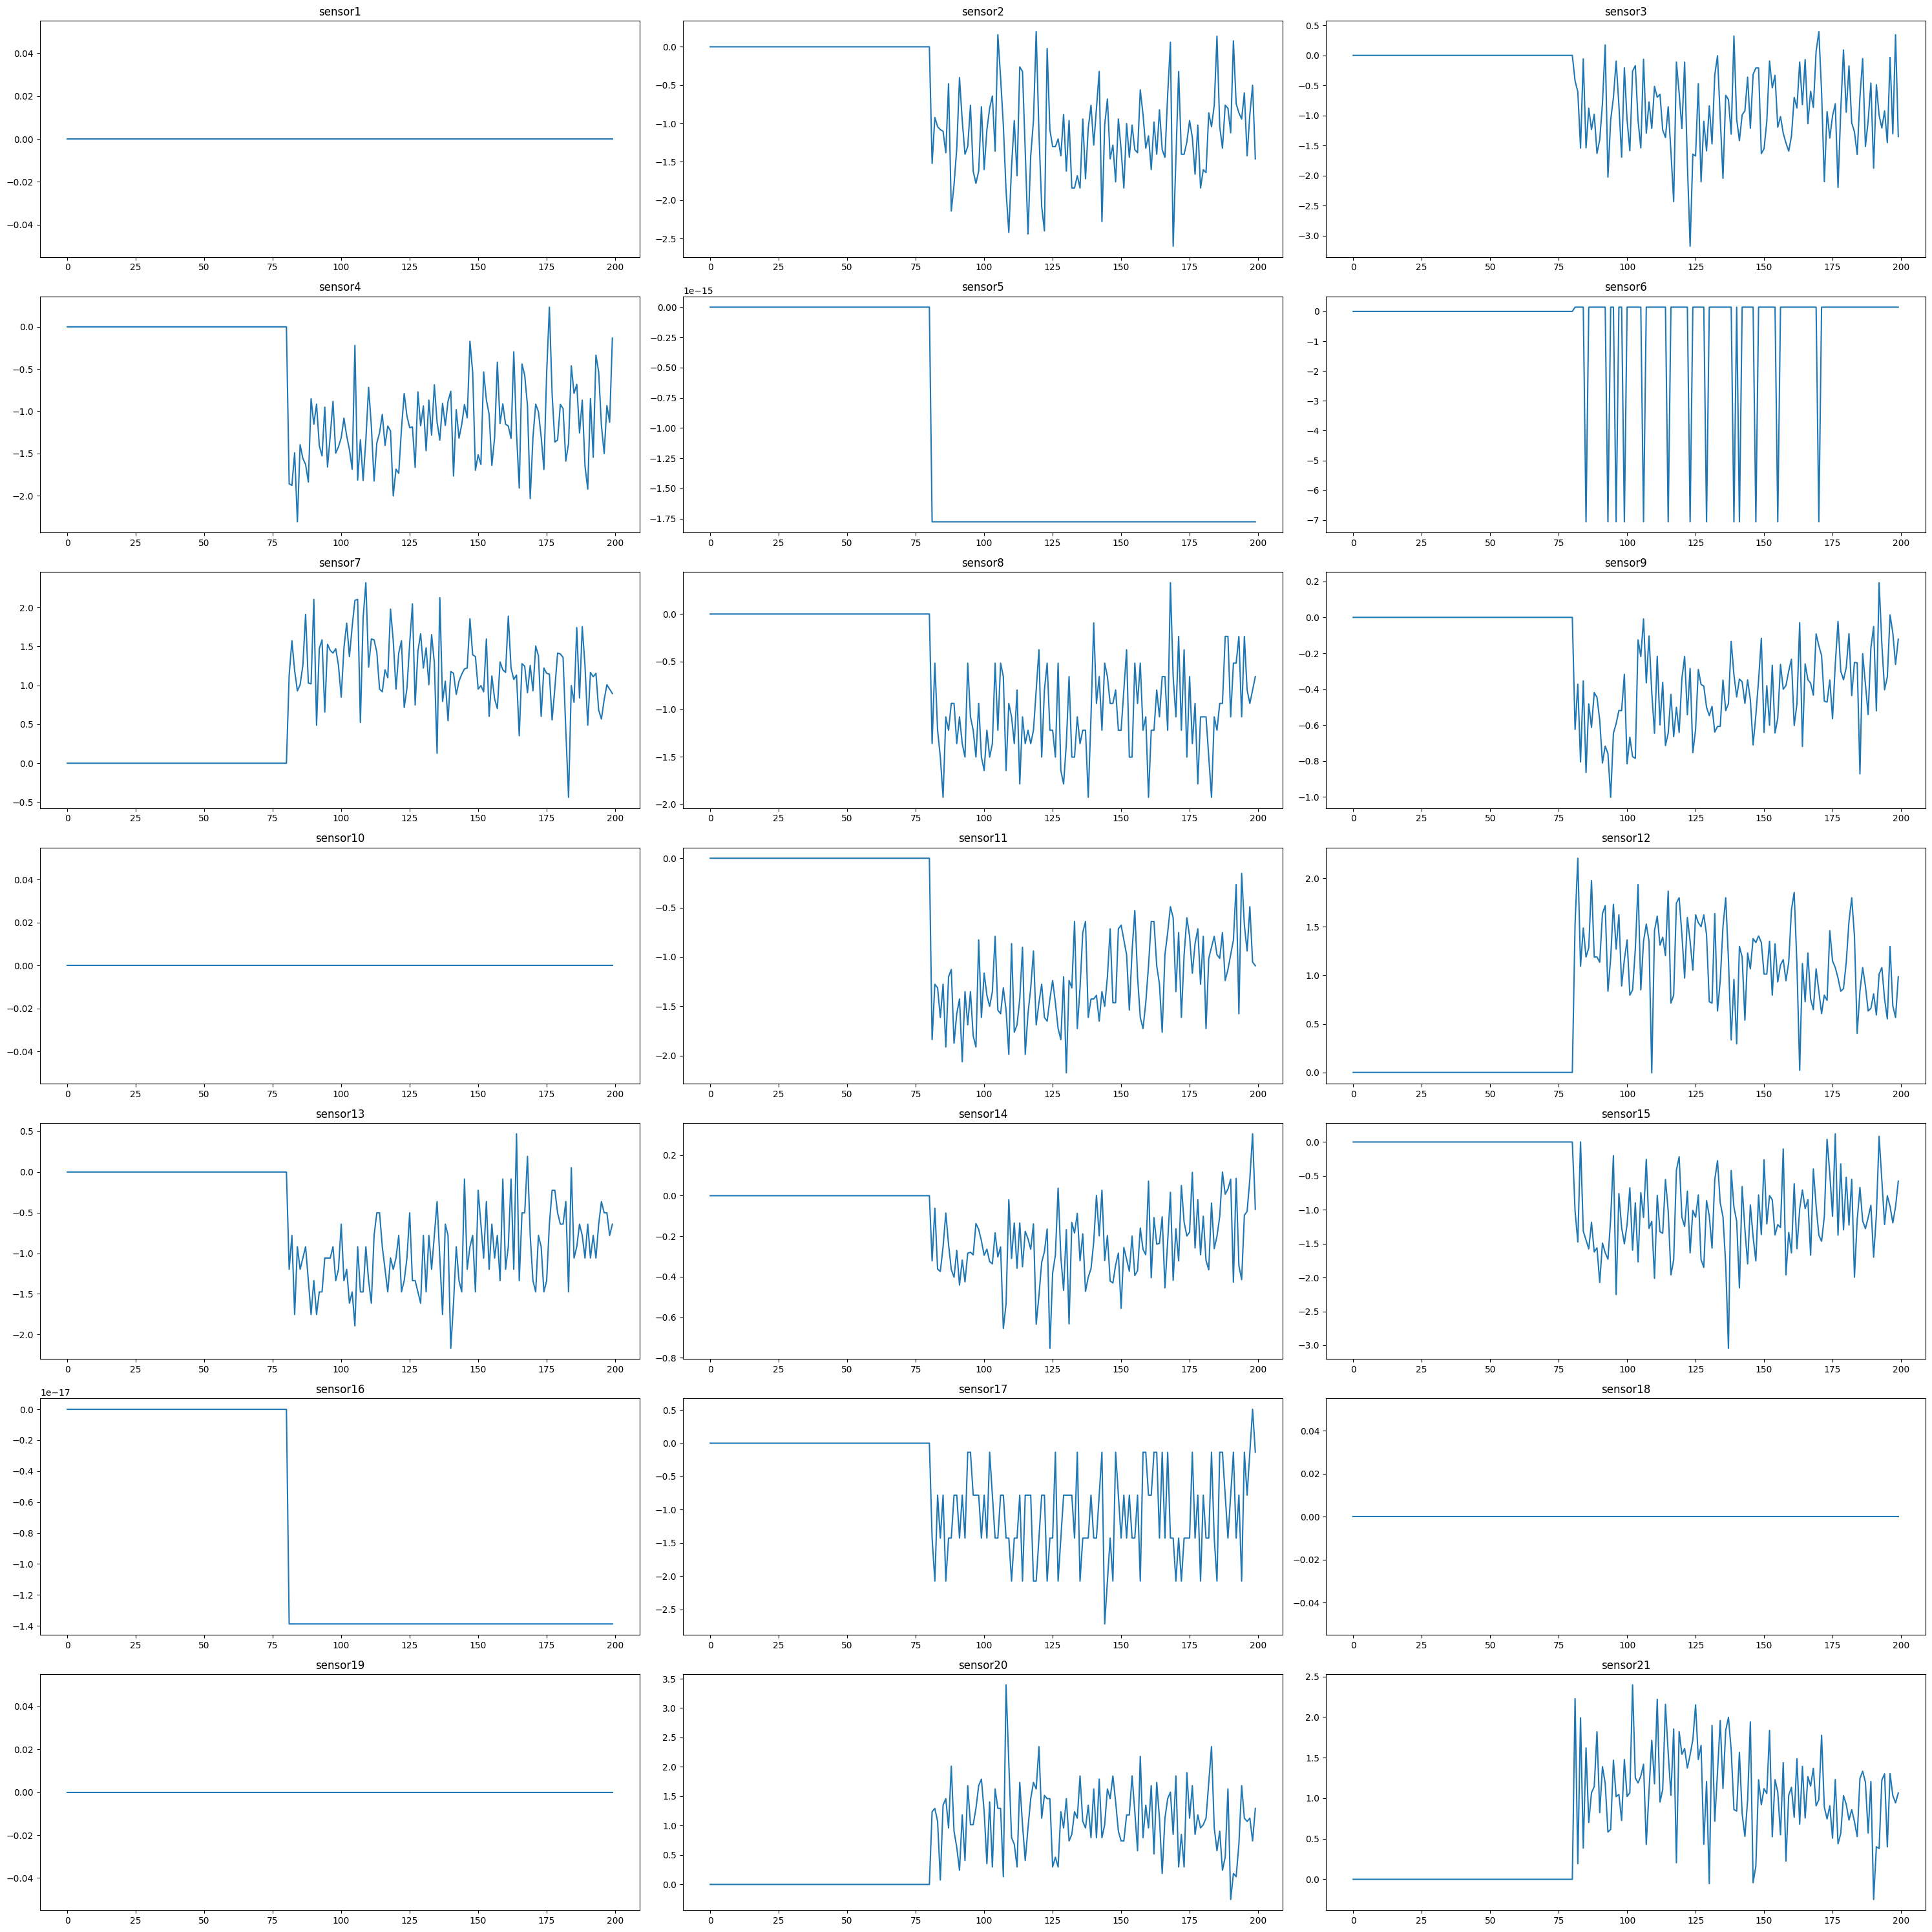

In [31]:
plotDataForIndex(padded_train, 450)

In [32]:
# selected_sensors = [7, 8, 9, 12, 16, 17, 20]
selected_sensors = [2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
# selected_sensors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
selected_sensors_indices = [x-1 for x in selected_sensors] # -1 because the index starts from 1

In [33]:
# X_train = padded_train[:, :, 5:26]
X_train = padded_train[:, :, 5:26][:, :, selected_sensors_indices]

In [34]:
# X_test = padded_test[:, :, 5:26]
X_test = padded_test[:, :, 5:26][:, :, selected_sensors_indices]

In [35]:
y_train = np.array(train_ruls).reshape(-1,1)
y_test = np.array(test_ruls).reshape(-1,1)

In [36]:
numOfSensors = len(X_train[0][0])

In [37]:
import codecs, json
def exportNPArrayToJSON(a, fileName):
    b = a.tolist() # nested lists with same data, indices
    json.dump(b, codecs.open(fileName, 'w', encoding='utf-8')) ### this saves the array in .json format

In [38]:
test_FD = 'test_FD00' + str(setNumber) + ".json"
train_FD = 'train_FD00' + str(setNumber) + ".json"
test_RUL_FD = 'test_RUL_FD00' + str(setNumber) + ".json"
train_RUL_FD = 'train_RUL_FD00' + str(setNumber) + ".json"
# exportNPArrayToJSON(X_train, train_FD)
exportNPArrayToJSON(X_test, test_FD)
# exportNPArrayToJSON(y_train, train_RUL_FD)
exportNPArrayToJSON(y_test, test_RUL_FD)

In [39]:
from IPython.display import FileLink

In [40]:
FileLink(test_FD)

/content/test_FD001.json

In [41]:
FileLink(test_RUL_FD)

/content/test_RUL_FD001.json

In [42]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten

# from keras import backend as K
# K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=36, inter_op_parallelism_threads=36)))


def createModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=inputShape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    do1 = Dropout(0.2)

    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    do2 = Dropout(0.2)

    flatten = Flatten()

    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    do3 = Dropout(0.2)

    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    do4 = Dropout(0.2)

    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    # combine the layers
#     layers = [lstm1, do1, lstm2, do2, dense1, do3, dense2, do4, outL]
    layers = [lstm1, lstm2, do2, flatten,  dense1, dense2, outL]
    # create the model
    model = Sequential(layers)
    model.compile(optimizer='adam', loss='mse')
    return model

In [43]:
model = createModel(64, 64, 64, 8, (maxlen, numOfSensors))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 200, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 200, 64)           0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 64)                819264    
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9

In [45]:
from keras.models import Sequential
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

In [46]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input, Add
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os


In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, BatchNormalization

def createCNNLSTMModel(inputShape):
    model = Sequential()

    # Convolutional layers
    model.add(Conv1D(filters=18, kernel_size=2, strides=1, padding='same', activation='relu', input_shape=inputShape, name='cv1'))
    model.add(BatchNormalization(axis=-1, name='bn1'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp1'))

    model.add(Conv1D(filters=36, kernel_size=2, strides=1, padding='same', activation='relu', name='cv2'))
    model.add(BatchNormalization(axis=-1, name='bn2'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp2'))

    model.add(Conv1D(filters=72, kernel_size=2, strides=1, padding='same', activation='relu', name='cv3'))
    model.add(BatchNormalization(axis=-1, name='bn3'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp3'))

    # LSTM layers
    model.add(LSTM(inputShape[1] * 3, return_sequences=True, name='lstm1'))
    model.add(Dropout(0.2, name='dropout1'))

    model.add(LSTM(inputShape[1] * 3, name='lstm2'))
    model.add(Dropout(0.2, name='dropout2'))

    # Dense layers
    model.add(Dense(50, activation='relu', name='dense1'))
    model.add(Dropout(0.2, name='dropout3'))

    model.add(Dense(1, name='output'))

    model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model


In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, BatchNormalization

def createCNNLSTMModel(inputShape):
    model = Sequential()

    # Convolutional layers with Batch Normalization
    model.add(Conv1D(filters=18, kernel_size=2, strides=1, padding='same', activation='relu', input_shape=inputShape, name='cv1'))
    model.add(BatchNormalization(axis=-1, name='bn1'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp1'))

    model.add(Conv1D(filters=36, kernel_size=2, strides=1, padding='same', activation='relu', name='cv2'))
    model.add(BatchNormalization(axis=-1, name='bn2'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp2'))

    model.add(Conv1D(filters=72, kernel_size=2, strides=1, padding='same', activation='relu', name='cv3'))
    model.add(BatchNormalization(axis=-1, name='bn3'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp3'))

    # LSTM layers with Dropout
    model.add(LSTM(inputShape[1] * 3, return_sequences=True, name='lstm1'))
    model.add(Dropout(0.2, name='dropout1'))

    model.add(LSTM(inputShape[1] * 3, name='lstm2'))
    model.add(Dropout(0.2, name='dropout2'))

    # Dense layers
    model.add(Dense(50, activation='relu', name='dense1'))
    model.add(Dropout(0.2, name='dropout3'))

    model.add(Dense(1, name='output'))

    model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model


In [50]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
# ten fold
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)
from keras.models import load_model
msescores = []
counter= 0
for trainIdx, testIdx in kfold.split(X_train, y_train):
    counter = counter + 1
    # create callbacks
    model_path = 'best_model_set'+str(setNumber)+'fold'+str(counter)+'.h5'
    mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1)
    # create model
    # model = createModel(64, 64, 8, 8, (maxlen, numOfSensors))
    model = createCNNLSTMModel((maxlen, numOfSensors))
    model.fit(X_train[trainIdx], y_train[trainIdx], validation_data=(X_train[testIdx], y_train[testIdx]), batch_size=32, epochs=4, callbacks=[mc, es])
    # Done load the best model of this fold
    saved_model = load_model(model_path)
    msescores.append({'path': model_path, 'mse': saved_model.evaluate(X_train[testIdx], y_train[testIdx])})

Epoch 1/4
140/141 [============================>.] - ETA: 0s - loss: 3799.1536 - root_mean_squared_error: 61.6373
Epoch 1: val_loss improved from inf to 1240.61560, saving model to best_model_set1fold1.h5
141/141 [==============================] - 15s 62ms/step - loss: 3789.1343 - root_mean_squared_error: 61.5559 - val_loss: 1240.6156 - val_root_mean_squared_error: 35.2224
Epoch 2/4
  1/141 [..............................] - ETA: 9s - loss: 1178.7911 - root_mean_squared_error: 34.3335

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



140/141 [============================>.] - ETA: 0s - loss: 612.7576 - root_mean_squared_error: 24.7539
Epoch 2: val_loss improved from 1240.61560 to 329.17300, saving model to best_model_set1fold1.h5
141/141 [==============================] - 7s 48ms/step - loss: 611.7138 - root_mean_squared_error: 24.7328 - val_loss: 329.1730 - val_root_mean_squared_error: 18.1431
Epoch 3/4
141/141 [==============================] - ETA: 0s - loss: 319.0388 - root_mean_squared_error: 17.8617
Epoch 3: val_loss improved from 329.17300 to 175.18991, saving model to best_model_set1fold1.h5
141/141 [==============================] - 7s 50ms/step - loss: 319.0388 - root_mean_squared_error: 17.8617 - val_loss: 175.1899 - val_root_mean_squared_error: 13.2359
Epoch 4/4
140/141 [============================>.] - ETA: 0s - loss: 282.5323 - root_mean_squared_error: 16.8087
Epoch 4: val_loss improved from 175.18991 to 111.24613, saving model to best_model_set1fold1.h5
16/16 [==============================] - 1s 13

In [51]:
msescores

[{'path': 'best_model_set1fold1.h5',
  'mse': [111.24613189697266, 10.547327995300293]},
 {'path': 'best_model_set1fold2.h5',
  'mse': [179.28802490234375, 13.389847755432129]},
 {'path': 'best_model_set1fold3.h5',
  'mse': [123.17597198486328, 11.098466873168945]},
 {'path': 'best_model_set1fold4.h5',
  'mse': [184.6897430419922, 13.590060234069824]},
 {'path': 'best_model_set1fold5.h5',
  'mse': [180.96261596679688, 13.452234268188477]},
 {'path': 'best_model_set1fold6.h5',
  'mse': [167.13755798339844, 12.928169250488281]},
 {'path': 'best_model_set1fold7.h5',
  'mse': [141.42799377441406, 11.892350196838379]},
 {'path': 'best_model_set1fold8.h5',
  'mse': [129.57867431640625, 11.383262634277344]},
 {'path': 'best_model_set1fold9.h5',
  'mse': [153.59739685058594, 12.393442153930664]},
 {'path': 'best_model_set1fold10.h5',
  'mse': [257.103271484375, 16.034440994262695]}]

In [52]:

for md in msescores:
    saved_model = load_model(md['path'])
    print(saved_model.evaluate(X_test, y_test))

4/4 [==============================] - 1s 13ms/step - loss: 322.5397 - root_mean_squared_error: 17.9594
[322.53973388671875, 17.95939064025879]
4/4 [==============================] - 1s 18ms/step - loss: 304.7281 - root_mean_squared_error: 17.4565
[304.72808837890625, 17.456462860107422]
4/4 [==============================] - 2s 21ms/step - loss: 255.6752 - root_mean_squared_error: 15.9898
[255.67520141601562, 15.989847183227539]
4/4 [==============================] - 1s 11ms/step - loss: 270.3038 - root_mean_squared_error: 16.4409
[270.3038024902344, 16.44091796875]
4/4 [==============================] - 1s 11ms/step - loss: 335.5538 - root_mean_squared_error: 18.3181
[335.5538024902344, 18.31812858581543]
4/4 [==============================] - 1s 12ms/step - loss: 318.9816 - root_mean_squared_error: 17.8601
[318.98162841796875, 17.860055923461914]
4/4 [==============================] - 1s 12ms/step - loss: 301.8917 - root_mean_squared_error: 17.3750
[301.8917236328125, 17.37503242492

In [53]:
predicted = saved_model.predict(X_test)

4/4 [==============================] - 1s 15ms/step


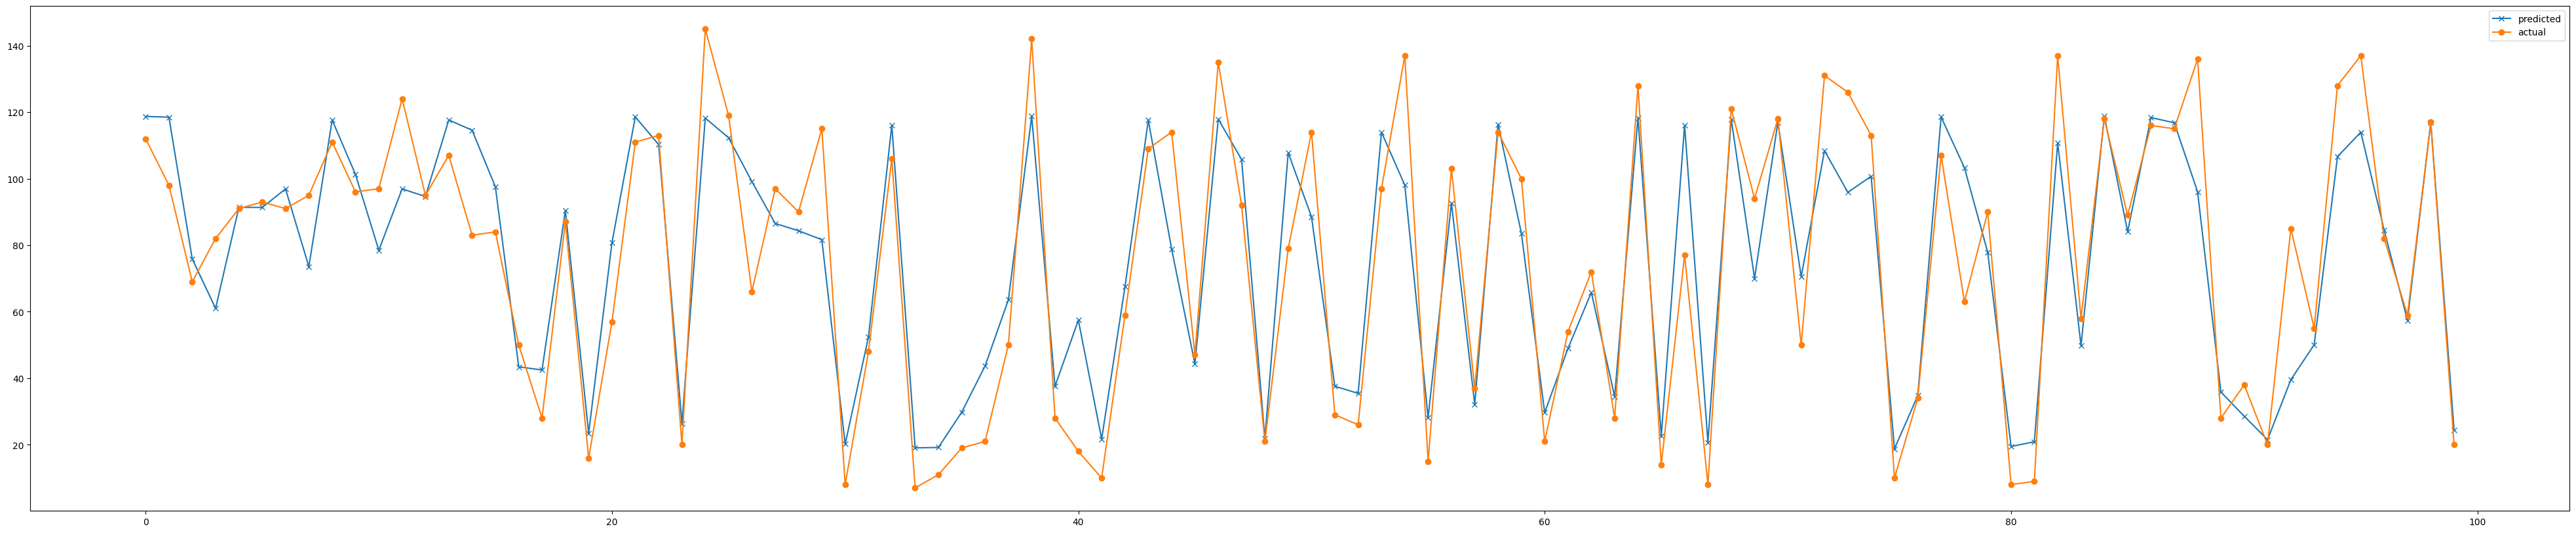

In [54]:
plt.figure(figsize=(50, 10))
plt.plot(range(len(predicted)), predicted, '-x', label='predicted')
plt.plot(range(len(y_test)), y_test, '-o', label='actual')
plt.legend()

In [55]:
from keras.models import Model
def getVizModel(model):
    output_layers = [l.output for l in model.layers]
    viz_model = Model(saved_model.input, output_layers)
    return viz_model

In [56]:
viz_model = getVizModel(saved_model)

In [57]:
layer_outputs = viz_model.predict(X_train)

157/157 [==============================] - 3s 16ms/step


In [58]:
layer_outputs[0].shape

(5000, 200, 18)

In [59]:
import math
def plotLayerData(layer_data, mcIndex):
    mcData = layer_data[mcIndex]
    plt.figure(figsize=(30, 30))
    nCols = 2
    nRows = math.ceil(len(mcData[0])/nCols)
    for i in range(len(mcData[0])):
        plt.subplot(nRows, nCols, i+1)
        plt.plot(range(len(mcData[:, i])), mcData[:, i])
        plt.tight_layout()

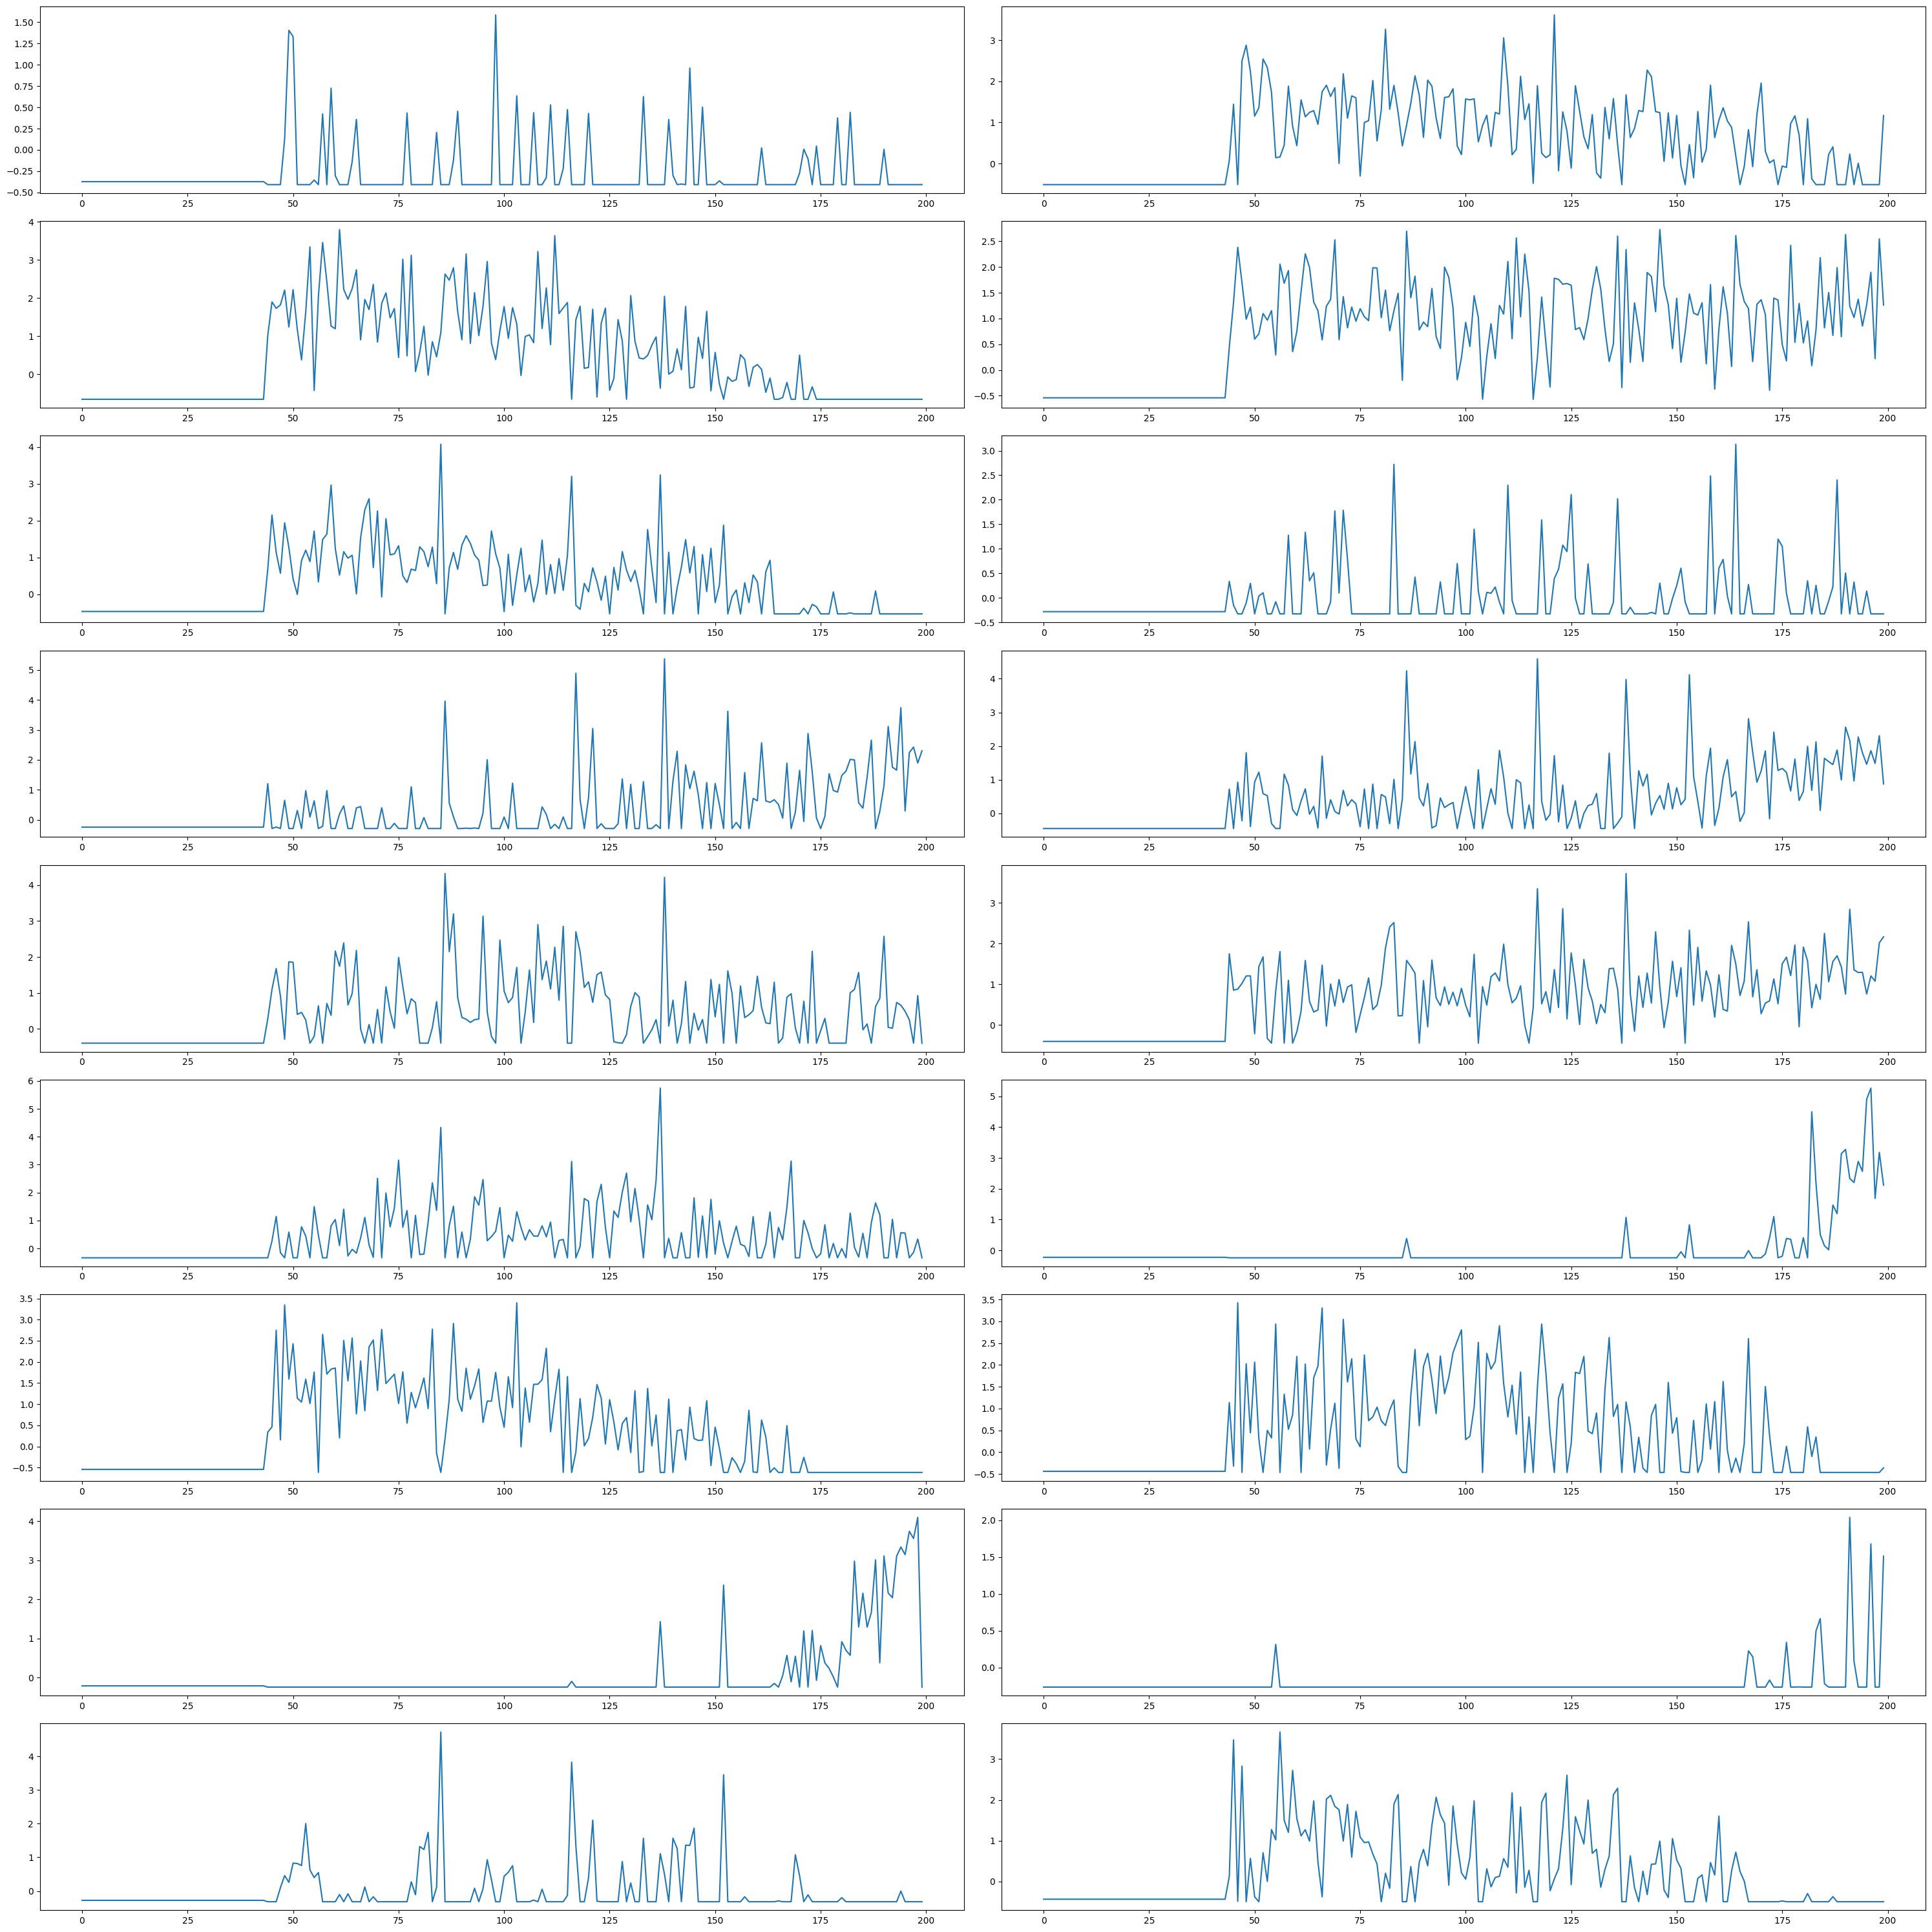

In [60]:
plotLayerData(layer_outputs[1], 100)

In [61]:
import seaborn as sns
def plotLayerHeatmap(layer_data, mcIndex):
    mcData = layer_data[mcIndex]
    plt.figure(figsize=(30, 10))
    sns.heatmap(mcData.transpose())

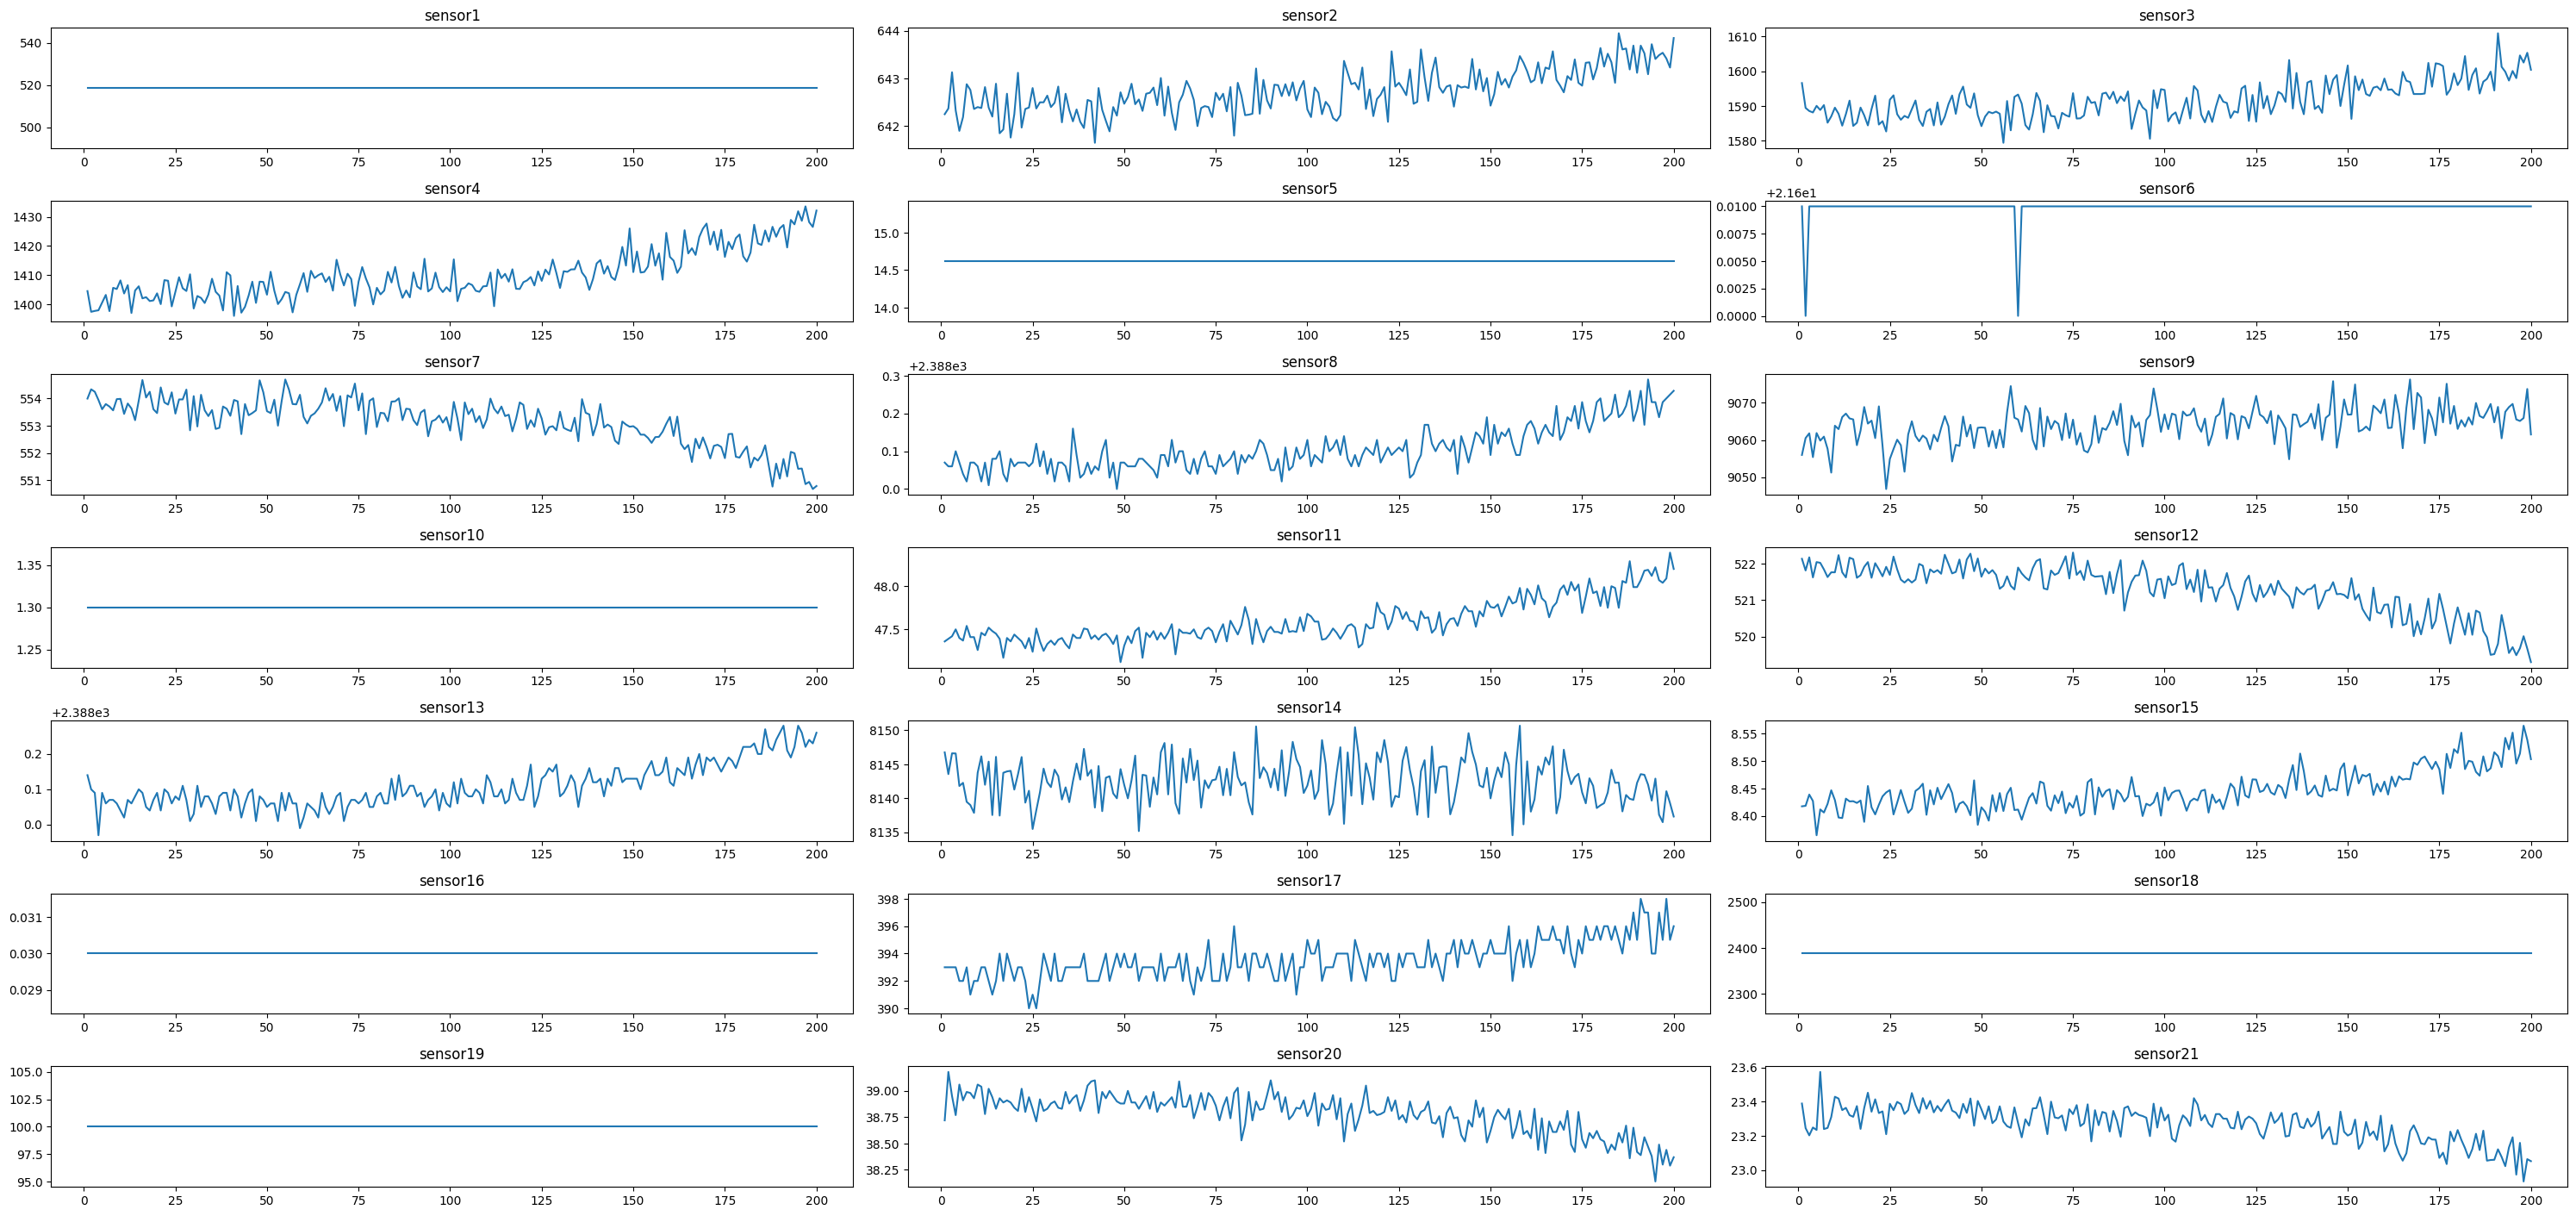

In [62]:
plotSensorDataOfId(train, 100)

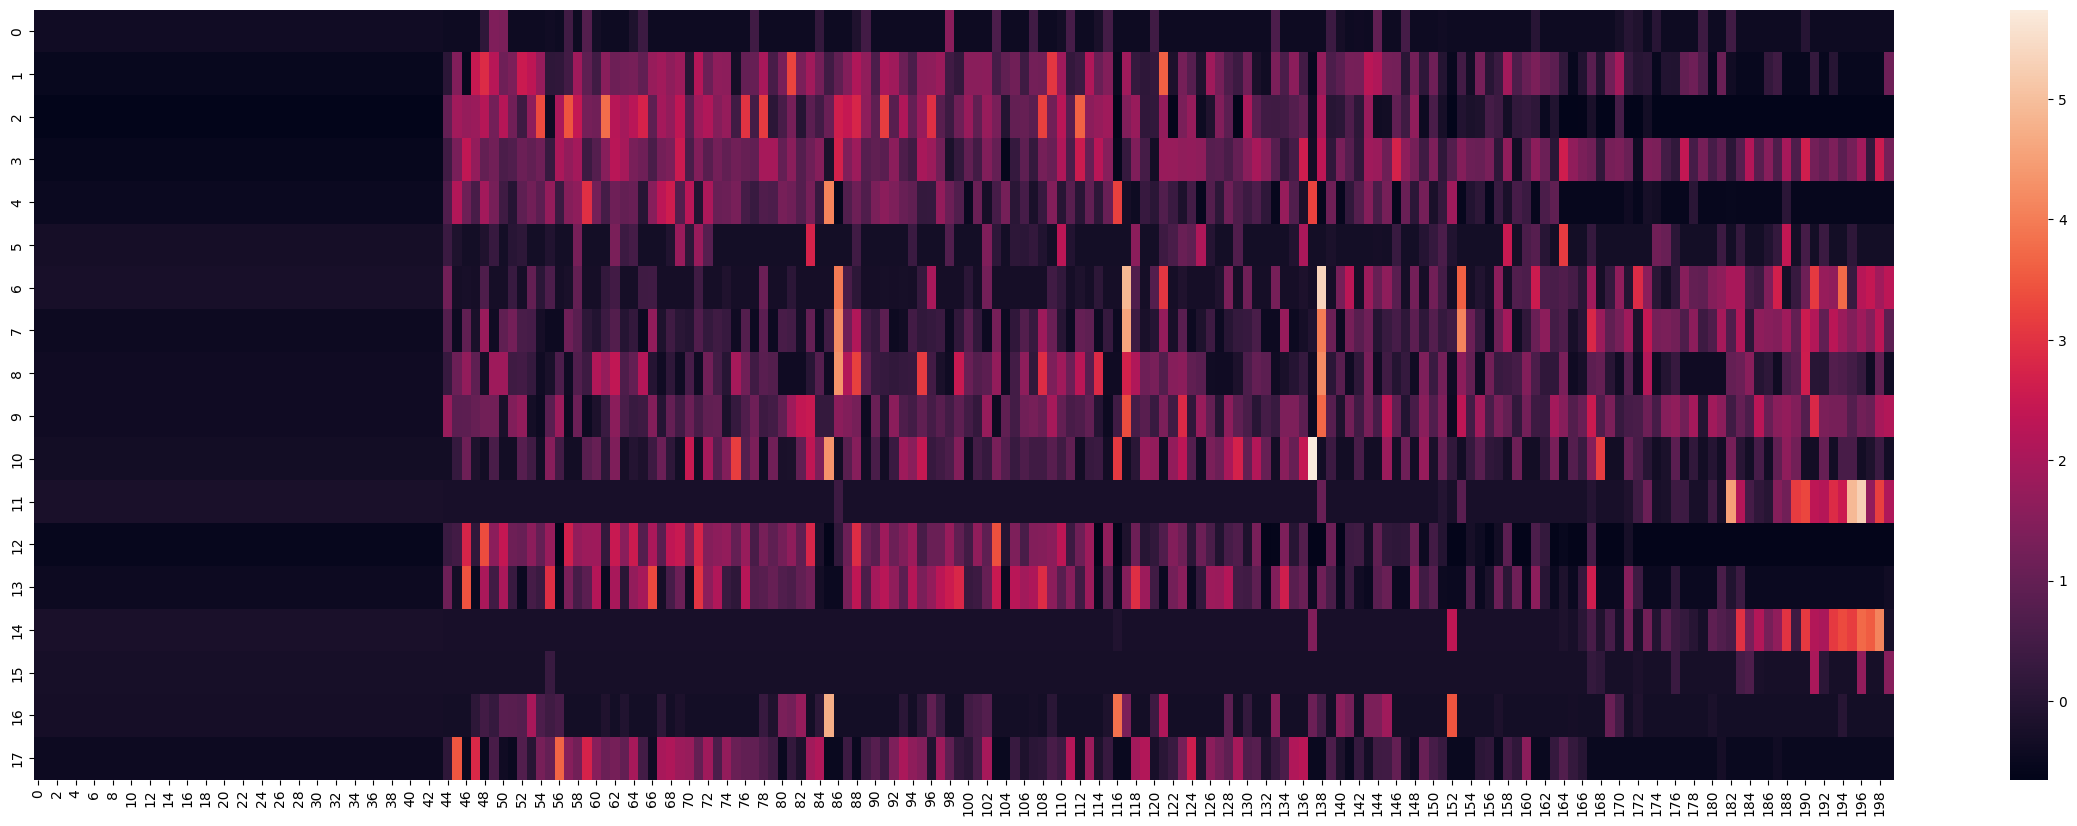

In [63]:
plotLayerHeatmap(layer_outputs[1], 100)